### Visualizing Options Pricer

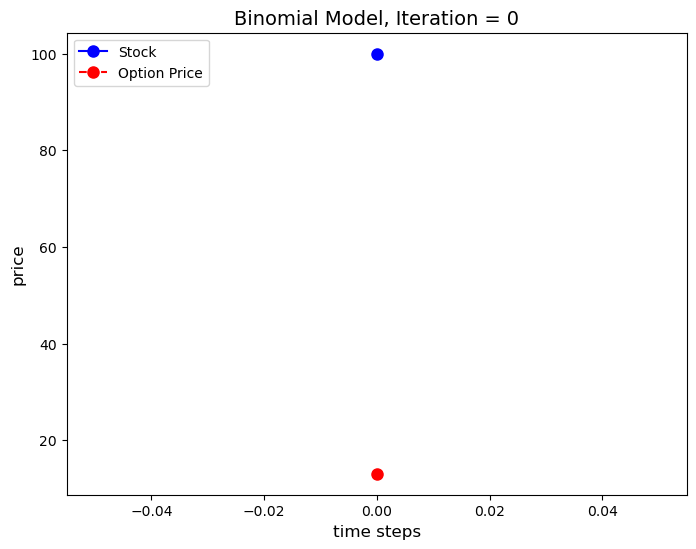

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from matplotlib.animation import PillowWriter
from IPython.display import HTML

# parameters for option pricing
S0 = 100
K = 100
T = 1     # time to maturity (in years)
r = 0.1  # risk-free rate
sigma = 0.2  # volatility
n_steps = 12  # number of time steps in binomial tree

# binomial tree model for american option pricing
def binomial_tree_american(S0, K, T, r, sigma, n_steps):
    # time step size
    dt = T / n_steps
    # up and down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    # risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # create stock and option trees
    stock_tree = np.zeros((n_steps + 1, n_steps + 1))
    option_tree = np.zeros((n_steps + 1, n_steps + 1))

    # calculate stock prices at each node
    for i in range(n_steps + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # calculate option payoff at maturity
    for j in range(n_steps + 1):
        option_tree[j, n_steps] = max(stock_tree[j, n_steps] - K, 0)

    # work backwards to price the option
    for i in range(n_steps - 1, -1, -1):
        for j in range(i + 1):
            exercise = max(stock_tree[j, i] - K, 0)
            hold = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            option_tree[j, i] = max(exercise, hold)

    return stock_tree, option_tree

# visualization
def create_option_pricing_gif():
    # generate binomial tree for stock and option prices
    stock_tree, option_tree = binomial_tree_american(S0, K, T, r, sigma, n_steps)

    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f"Binomial Model, Iteration = {frame}", fontsize=14)
        ax.set_xlabel("time steps", fontsize=12)
        ax.set_ylabel("price", fontsize=12)

        # plot stock prices at the current step
        for i in range(frame + 1):
            ax.plot([i] * (i + 1), stock_tree[:i + 1, i], 'bo-', markersize=8, label='Stock' if i == 0 else "")

        # plot option prices at the current step
        for i in range(frame + 1):
            ax.plot([i] * (i + 1), option_tree[:i + 1, i], 'ro--', markersize=8, label='Option Price' if i == 0 else "")

        # draw arrows to indicate backward induction for option pricing
        if frame > 0:
            for j in range(frame):
                for i in range(j + 1):
                    ax.add_patch(FancyArrowPatch((j, stock_tree[i, j]), (j + 1, stock_tree[i, j + 1]), color='gray', arrowstyle='->', mutation_scale=10))
                    ax.add_patch(FancyArrowPatch((j, stock_tree[i, j]), (j + 1, stock_tree[i + 1, j + 1]), color='gray', arrowstyle='->', mutation_scale=10))
        
        # highlight the final payoff at maturity
        if frame == n_steps:
            ax.fill_between(np.arange(n_steps + 1), option_tree[:, n_steps], color='green', alpha=0.45, label='Early Exercise Region')

        # add labels and legend
        ax.legend(loc='upper left')

    # create animation
    ani = FuncAnimation(fig, update, frames=range(n_steps + 1), repeat=False)
    
    return ani

# display the animation inline in jupyter
ani = create_option_pricing_gif();
HTML(ani.to_jshtml())
ani.save("option_pricing.gif", writer=PillowWriter(fps=10), dpi=300)